# High Value Customer Identification (Insiders)

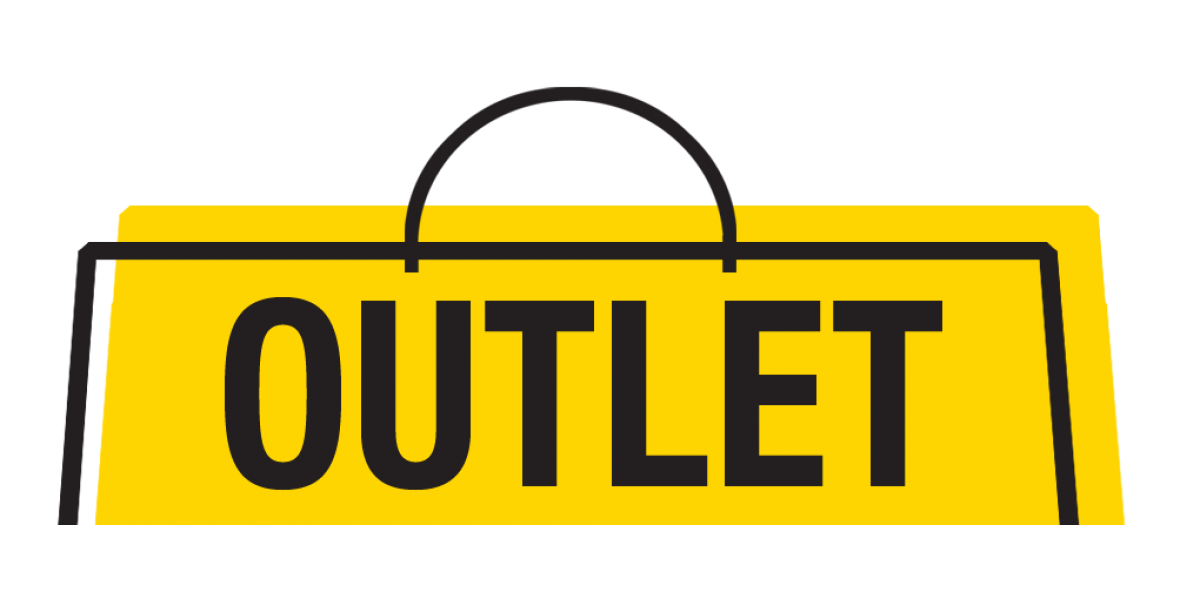

The company All in One Place is a Multibrand Outlet company, i.e., it sells second line products of various brands at a lower price, through an e-commerce platform. In 1 year of operation, the marketing team realized that some customers in its base buy more expensive products with high frequency and end up contributing with a significant portion of the company's revenue. Based on this perception, the marketing team will launch a loyalty program for the best customers in the base, called Insiders. But the team does not have an advanced knowledge of data analysis to choose the program participants. For this reason, the marketing team asked the data team to select eligible customers for the program, using advanced data manipulation techniques.

**Table of contents**

* 0.0. [Imports](#imports)

# Solution Planning (IOT) <a id='solution_planning'></a>

## Input <a id='input'></a>

1. Business Problem
    * Select most valuable customers to join a loyalty program.
2. Dataset
    * E-commerce online sales, for 1 year.

## Output  <a id='output'></a>

1. List of customers who will join the Insiders program.
    * List:
    | client_id | is_insider |
    | ---  | --- |
    | 10323 | yes/1 |
    | 10323 | no/0 |
    
2. Aswer business questions

    1. Who are the people eligible to join the Insiders program?
    2. How many customers will be part of the group?
    3. What are the main characteristics of these customers?
    4. What is the percentage of revenue contribution coming from the Insiders?
    5. What is the expected revenue of this group for the next months?
    6. What are the conditions for a person to be eligible to join Insiders?
    7. How can a person be removed from the Insiders program?
    8. What is the guarantee that the Insiders program is better than the rest of the base ?
    9. What actions can the marketing team take to increase revenue?

## Tasks <a id='tasks'></a>

**1. Who are the people eligible to join the Insiders program?**

* What is being eligible? What are most valuable customers?
* Revenue:
    * High average ticket
    * High LTV (Life Time Value)
    * Low Recency (Las time of purcharse)
    * Big basket size
    * Low churn probability
    * High LTV Prediction
    * High propensity to buy
* Cost:
    * Low return rate
* Shopping experience:
    * High average evaluation

**2. How many customers will be part of the group?**

* Total number of customers
* % of Insiders Group

**3. What are the main characteristics of these customers?**

* Get some customer's characteristics
    * Age
    * Localization

* Get consumption characteristics
    * Clustering attributes

**4. What is the percentage of revenue contribution coming from the Insiders?**

* Anual total revenue
* Insiders' revenue

**5. What is the expected revenue of this group for the next months?**

* Insiders' LTV
* Cohort Analysis

**6. What are the conditions for a person to be eligible to join Insiders?**

* Define model periodicity (1, 3 months)
* The person should be similar to the selected customers.

**7. How can a person be removed from the Insiders program?**

* Define model periodicity (1, 3 months)
* The person should be different to the selected customers.

**8. What is the guarantee that the Insiders program is better than the rest of the base ?**

* Hypothesis Testing
* A/B Testing
* A/B Bayesian Testing

**9. What actions can the marketing team take to increase revenue?**

* Discount
* Purcharse preference
* Shipping
* Company visit

## Solution Benchmark <a id='solution_benchmark'></a>

* RFM Score

<img src="./img/rfm.png" alt="RFM" style="width: 600px;"/>

# 0.0. Imports <a id='imports'></a>

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from pandas_profiling import ProfileReport

from umap.umap_ import UMAP

from IPython.display import HTML

init_notebook_mode(connected=True)

D:\Anaconda\envs\py385\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\py385\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\Anaconda\envs\py385\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 0.1. Helper Functions <a id='helper_functions'></a>

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()

In [3]:
jupyter_settings()

## 0.1. Load dataset <a id='load_dataset'></a>

In [4]:
# load data
df_raw = pd.read_csv('data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw.drop(df_raw.columns[len(df_raw.columns)-1], axis=1, inplace=True)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Data Description <a id='data_description'></a>

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns <a id='rename_columns'></a>

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions <a id='data_dimensions'></a>

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types <a id='data_types'></a>

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check Missing Values <a id='check_na'></a>

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill Missing Values <a id='fill_na'></a>

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [12]:
# create reference for customer_id
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original data with reference dataframe
df1 = df1.merge(df_backup, on = 'invoice_no', how = 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change DTypes <a id='change_dtypes'></a>

In [14]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7. Descriptive Statistical <a id='descriptive_statistical'></a>

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes <a id='numerical_attributes'></a>

In [17]:
num = num_attributes.describe().T
num['skew'] = num_attributes.apply(lambda x: x.skew())
num['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
num

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0,-0.264076,119769.160031
unit_price,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0,186.506972,59005.719097


**Investigate**
1. Negative quantity
2. Min unit_price equal 0

### 1.7.2. Categorical Attributes <a id='categorical_attributes'></a>

#### Invoice No

In [18]:
cat_attributes.head()

,invoice_no,stock_code,description,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,17850


In [19]:
# number of invoice_no that has letters inside it
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(f'Number of distinct invoice_no that has letter in it: {len(df_letter_invoices.invoice_no.unique())}')
print(f'Number of total invoice_no that has letter in it: {len(df_letter_invoices)}')
n = len(df_letter_invoices.loc[df_letter_invoices['quantity'] < 0])
print(f'Number of invoice_no that has letter in it and quantity is less than 0: {n}')
df_letter_invoices.head()

Number of distinct invoice_no that has letter in it: 3839
Number of total invoice_no that has letter in it: 9254
Number of invoice_no that has letter in it and quantity is less than 0: 9251


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548


**To do:**

* Use negative values in feature engineering

#### Stock Code

In [20]:
# number of stock_code that has letters inside it
aux = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

1124


,invoice_no,stock_code,description,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,17850
45,536370,POST,POSTAGE,France,12583


In [21]:
# number of stock_code that has ONLY letters inside it
aux = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

12


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


In [22]:
# distinct stock_code with only letters
aux['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

**To do:**

* Remove stock_code in: 'POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'

#### Description

**To do:**

* Remove Description

#### Country

In [23]:
# countries in dataset
len(df1['country'].unique())

38

In [24]:
# check purchase's volumetry
df1['country'].value_counts(normalize = True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [25]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0. Data Filtering <a id='data_filtering'></a>

In [26]:
df2 = df1.copy()

In [27]:
df2.loc[df2['unit_price'] > 0.001, ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10)

,customer_id,description,unit_price
108088,16422,Discount,0.01
355050,16422,Manual,0.03
4287,15838,ROTATING SILVER ANGELS T-LIGHT HLDR,0.03
182729,12901,Discount,0.03
325477,12627,POPART WOODEN PENCILS ASST,0.04
427893,13822,POPART WOODEN PENCILS ASST,0.04
344823,14124,POPART WOODEN PENCILS ASST,0.04
228959,14282,POPART WOODEN PENCILS ASST,0.04
400464,12474,POPART WOODEN PENCILS ASST,0.04
269871,13081,POPART WOODEN PENCILS ASST,0.04


In [28]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code != 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# country
df2 = df2[~df2['country'].isin(['Unspecified', 'European Community'])]

# description
df2.drop(columns = 'description', inplace = True)

# quantity - Negative numbers means devolution
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchases = df2.loc[df2['quantity'] > 0, :].copy()

# 3.0. Feature Engineering <a id='feature_engineering'></a>

In [52]:
df3 = df2.copy()

## 3.1. Feature Creation <a id='feature_creation'></a>

In [53]:
# data reference
df_ref = df3.drop(columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']) \
            .drop_duplicates(ignore_index = True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1. Gross Revenue <a id='gross_revenue'></a>

In [54]:
# Gross Revenue = quantity * price
df2_purchases['gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_monetary, how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Last Purchase <a id='recency'></a>

In [55]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = df_ref.merge(df_recency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Total Purchases <a id='total_purchases'></a>

In [56]:
# Total Purchases
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates() \
                                                      .groupby('customer_id') \
                                                      .count() \
                                                      .reset_index() \
                                                      .rename(columns = {'invoice_no' : 'total_invoices'})
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_invoices    91
dtype: int64

### 3.1.4. Total Items Purchased <a id='total_items_purchased'></a>

In [57]:
# Total Products Purchases
df_freq = df2_purchases[['customer_id', 'quantity']].groupby('customer_id') \
                                                    .sum() \
                                                    .reset_index() \
                                                    .rename(columns = {'quantity' : 'total_items'})
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_invoices    91
total_items       91
dtype: int64

### 3.1.5. Total Products Purchased <a id='total_products_purchased'></a>

In [58]:
# Total Products Purchases
df_freq = df2_purchases[['customer_id', 'stock_code']].groupby('customer_id') \
                                                      .count() \
                                                      .reset_index() \
                                                      .rename(columns = {'stock_code' : 'total_products'})
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_invoices    91
total_items       91
total_products    91
dtype: int64

### 3.1.6. Average Ticket Value <a id='average_ticket_value'></a>

In [59]:
# Avg Ticket
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue' : 'avg_ticket'})
df_ref = df_ref.merge(df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_invoices    91
total_items       91
total_products    91
avg_ticket        91
dtype: int64

### 3.1.7. Average Recency <a id='average_recency'></a>

In [60]:
# Average Recency
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending = False)
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['next_date'] = df_aux['invoice_date'].shift()

df_aux['average_recency_days'] = df_aux.apply(lambda x: (x['next_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop(columns = ['invoice_date', 'next_customer_id', 'next_date'], axis = 1).dropna()

df_avg_recency = df_aux.groupby('customer_id').mean().reset_index()

df_ref = df_ref.merge(df_avg_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
total_invoices            91
total_items               91
total_products            91
avg_ticket                91
average_recency_days    2816
dtype: int64

### 3.1.8. Frequency Purchase  <a id='frequency_purchase'></a>

In [61]:
df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

In [62]:
df_aux = df2_purchases[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates() \
                                                                     .groupby('customer_id') \
                                                                     .agg(max_ = ('invoice_date', 'max'),
                                                                          min_ = ('invoice_date', 'min'),
                                                                          days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                          buy_ = ('invoice_no', 'count')).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = df_ref.merge(df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
total_invoices            91
total_items               91
total_products            91
avg_ticket                91
average_recency_days    2816
frequency                 91
dtype: int64

### 3.1.9. Returns  <a id='returns'></a>

In [63]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'returns'})
df_returns['returns'] = df_returns['returns'] * -1
df_ref = df_ref.merge(df_returns, on = 'customer_id', how = 'left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
total_invoices            91
total_items               91
total_products            91
avg_ticket                91
average_recency_days    2816
frequency                 91
returns                    0
dtype: int64

### 3.1.10. Basket Size  <a id='basket_size'></a>

Total products purchased.

* Invoice No = Purchase
* Stock Code = Product
* Quantity = Item

In [64]:
df_aux = df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id') \
                                                                        .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                             n_products = ('quantity', 'sum')) \
                                                                        .reset_index()

# calculate
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how = 'left', on = 'customer_id')

df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
total_invoices            91
total_items               91
total_products            91
avg_ticket                91
average_recency_days    2816
frequency                 91
returns                    0
avg_basket_size           91
dtype: int64

### 3.1.11. Unique Basket Size  <a id='basket_size'></a>

Distinct product quantity for each purchase.

In [65]:
df_aux = df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id') \
                                                                        .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                             n_products = ('stock_code', 'count')) \
                                                                        .reset_index()

# calculate
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how = 'left', on = 'customer_id')

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
total_invoices              91
total_items                 91
total_products              91
avg_ticket                  91
average_recency_days      2816
frequency                   91
returns                      0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0. EDA (Exploratory Data Analysis) <a id='eda'></a>

In [66]:
df4 = df_ref.dropna().copy()

## 4.1. Univariate Analysis <a id='univariate_analysis'></a>

In [67]:
# profile = ProfileReport(df4)
# profile.to_file('eda/eda_analysis.html')

### 4.1.1. Gross Revenue <a id='gross_revenue'></a>

In [69]:
df4.sort_values('gross_revenue', ascending = False).head()

,customer_id,gross_revenue,recency_days,total_invoices,total_items,total_products,avg_ticket,average_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,7.183333
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,7.326087
3338,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,28.507538


### 4.1.2. Total Items <a id='total_items'></a>

In [72]:
df4[df4['total_products'] == 7838]

,customer_id,gross_revenue,recency_days,total_invoices,total_items,total_products,avg_ticket,average_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.321429,0.33244,203.0,185.91129,63.209677


### 4.1.3. Average Ticket <a id='average_ticket'></a>

In [73]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,total_invoices,total_items,total_products,avg_ticket,average_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size
3338,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.009709,80995.0,40498.5,1.5


In [74]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


## 4.2. Bivariate Analysis <a id='bivariate_analysis'></a>

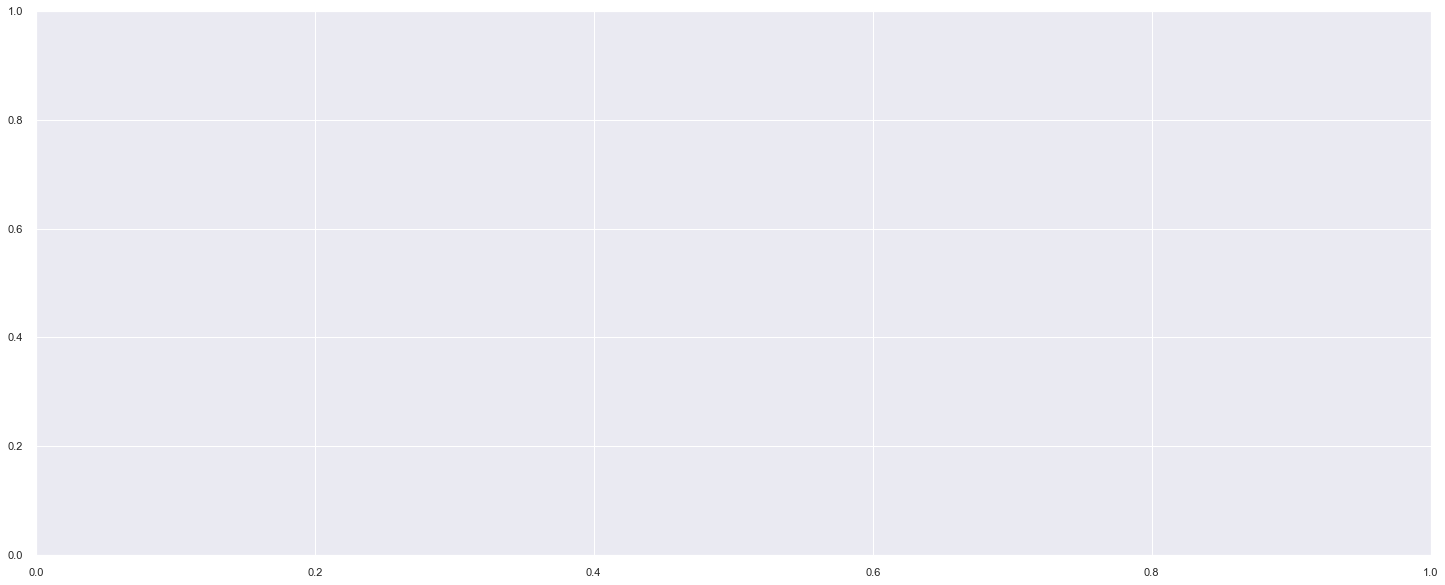

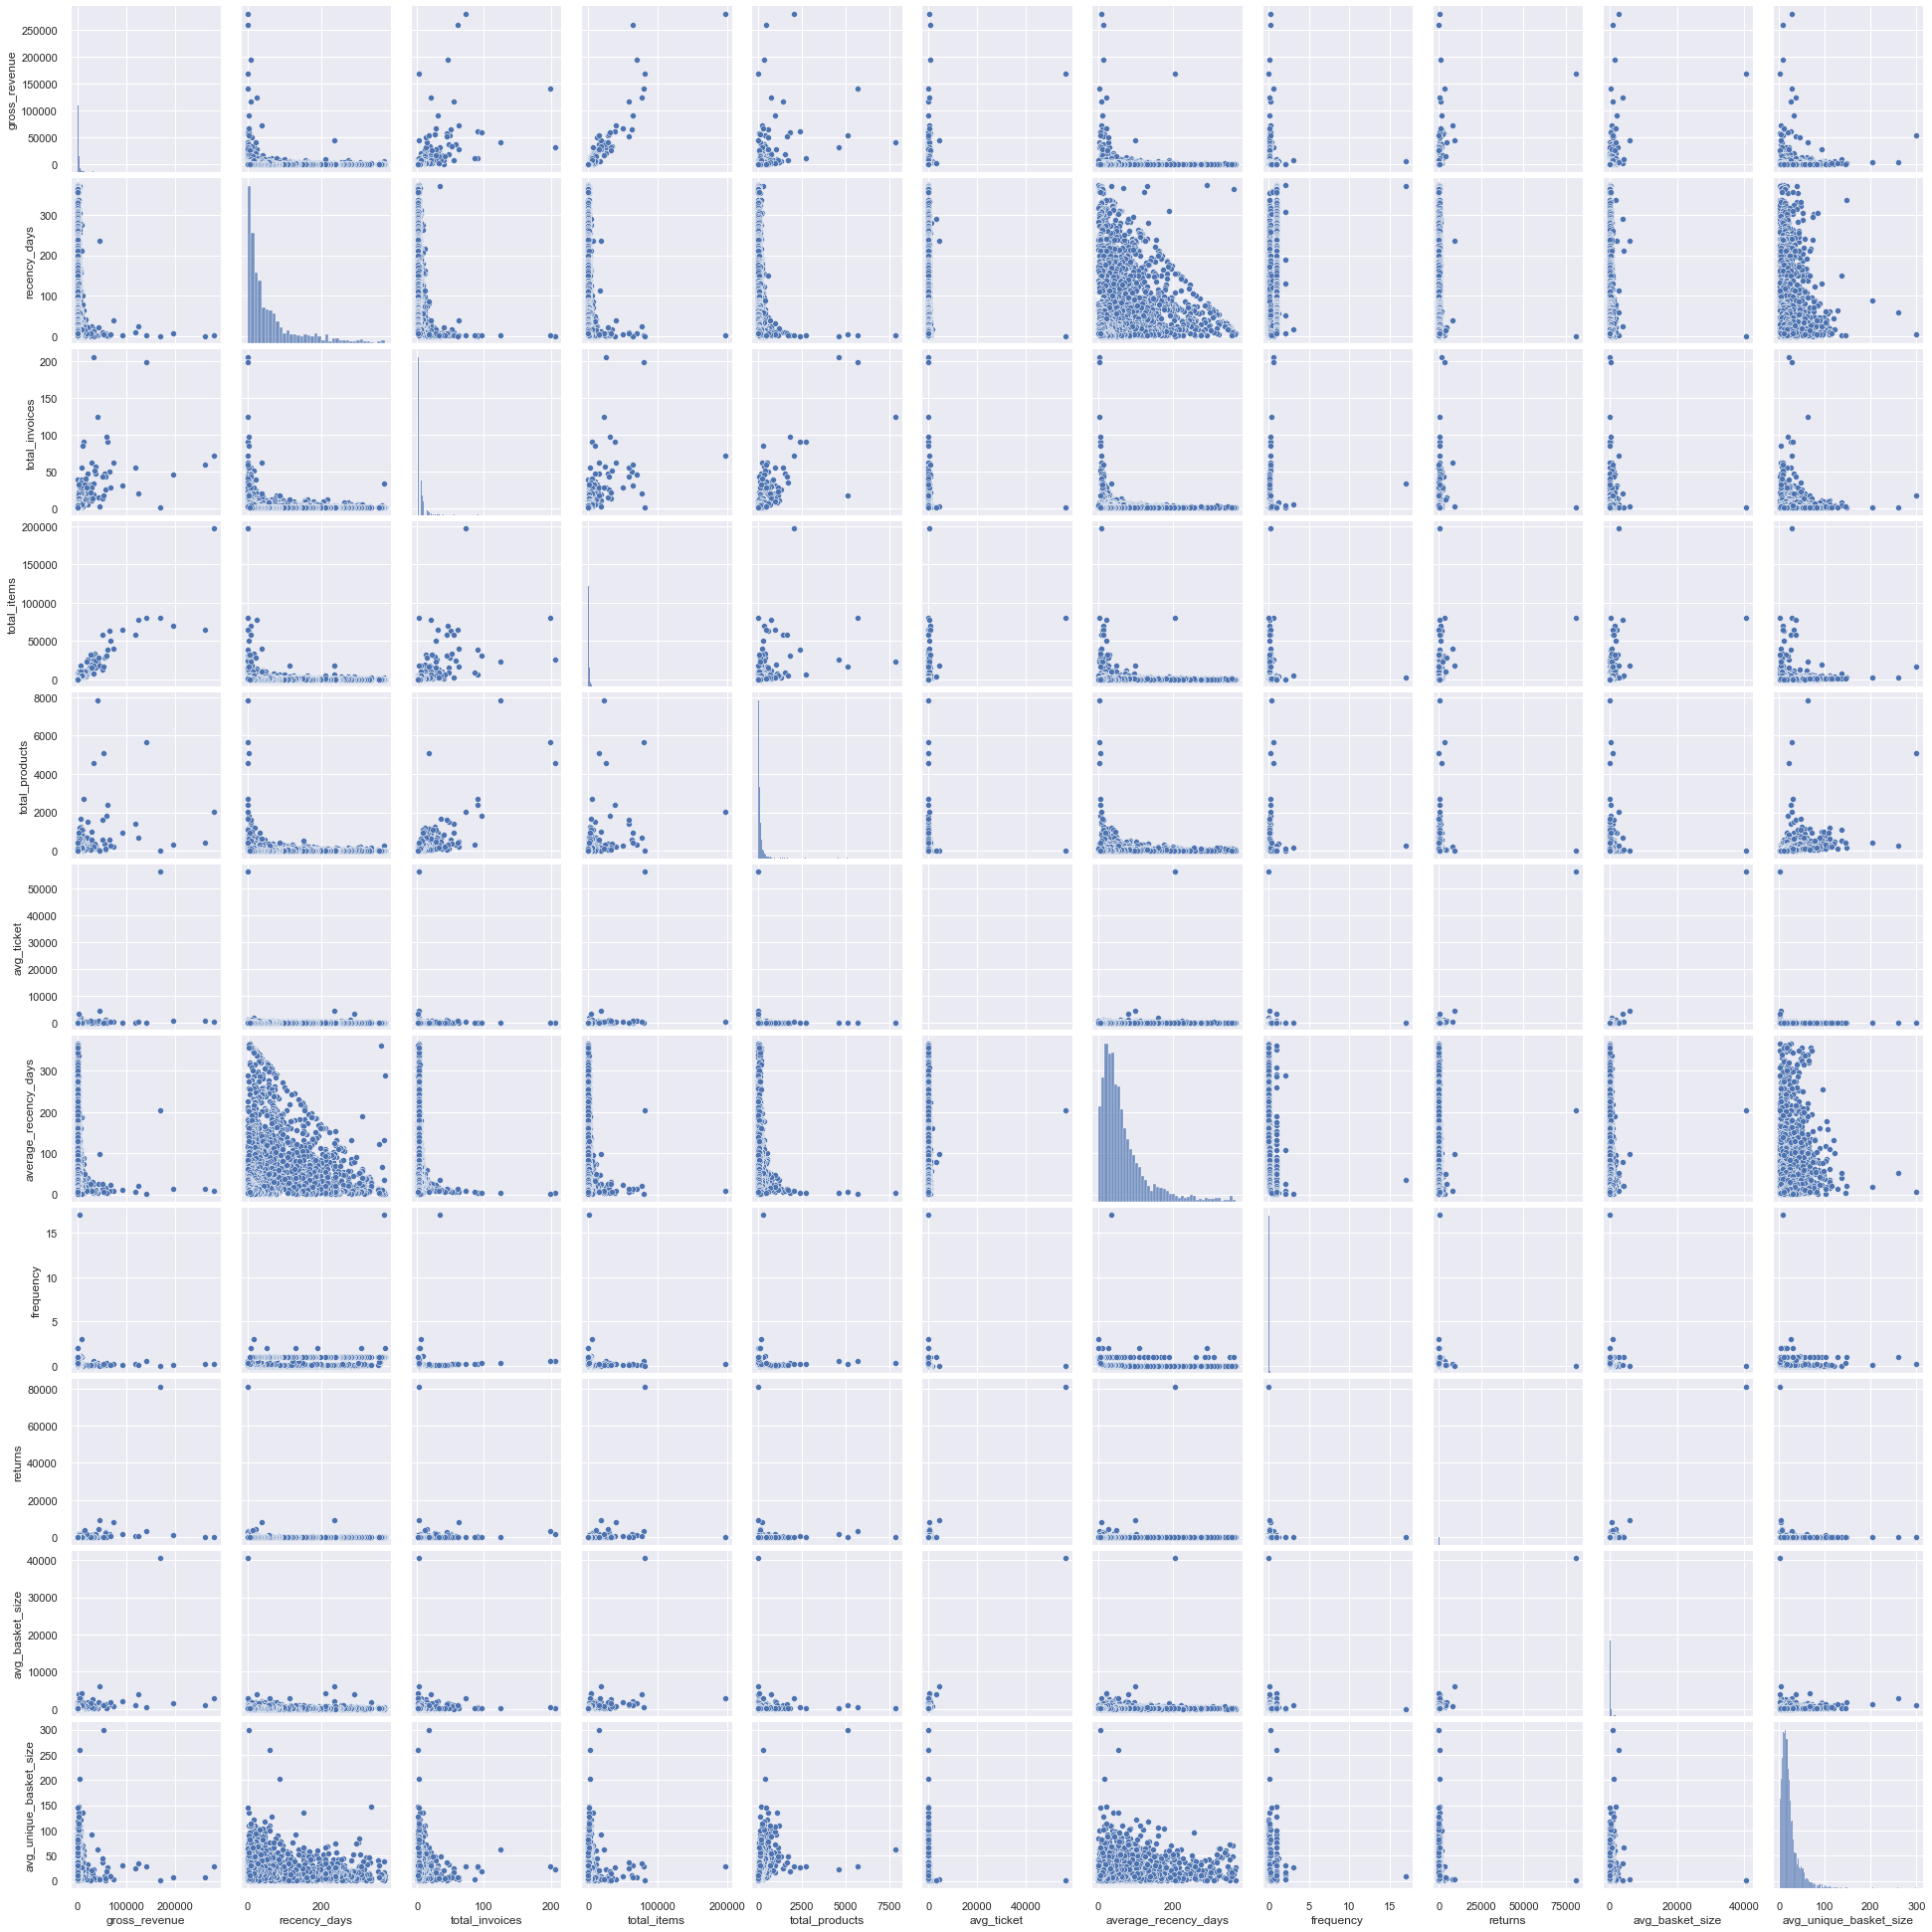

In [77]:
sns.pairplot(df4.drop(columns = 'customer_id'));

# 5. Data Preparation <a id='data_preparation'></a>

In [ ]:
df5 = df4.copy()

In [48]:
mms = MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
df5['invoice_no'] = mms.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])
df5['returns'] = mms.fit_transform(df5[['returns']])

NameError: name 'df5' is not defined

# 6.0. Feature Selection <a id='feature_selection'></a>

In [ ]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning <a id='hyperparameter'></a>

In [ ]:
X = df6.drop(columns = 'customer_id')

In [ ]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square <a id='within_cluster'></a>

In [ ]:
wss = []

for k in clusters:
    # model definition
    kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    
    # model training
    kmeans.fit(X)
    
    # validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method
fig = px.line(x=clusters, y=wss, markers = True, width=1200, height=400)
fig.update_layout(title='WSS Error for k Clusters',
                  xaxis_title="Clusters",
                  yaxis_title="WSS")
fig.update_traces(patch={"line": {"dash": 'dot'}}) 
fig.show()

In [ ]:
# wss with yellowbrick
kmeans = KElbowVisualizer(KMeans(), k = clusters, timings = False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score <a id='sillhouette_score'></a>

In [ ]:
# wss with yellowbrick
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric = 'silhouette', timings = False)
kmeans.fit(X)
kmeans.show();

## 7.3. Silhouette Analysis  <a id='sillhouette_analysis'></a>

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (25, 18))
for k in clusters:
    km = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 100, random_state = 42)
    visualizer = SilhouetteVisualizer(km, colors= 'yellowbrick', ax = ax.ravel()[k - min(clusters)])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0. Model Training <a id='model_training'></a>

## 8.1. K-Means <a id='kmeans'></a>

In [ ]:
# model definition
k = 5
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation <a id='cluster_validation'></a>

In [ ]:
# WSS (Within-cluster sum of squares)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
print(f'SS Value: {silhouette_score(X, labels, metric = "euclidean")}')

# 9.0. Cluster Analysis <a id='cluster_analysis'></a>

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

## 9.1. Visualization Inspection <a id='visualization_inspection'></a>

In [ ]:
# fig = px.scatter_3d(df9, x = 'recency_days', y = 'invoice_no', z = 'gross_revenue', color = 'cluster')
# fig.show()

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2D Plot <a id='2d_plot'></a>

In [ ]:
df_viz = df9.drop(columns = 'customer_id')
sns.pairplot(df_viz, hue = 'cluster');

## 9.3. UMAP <a id='umap'></a>

UMAP, t-SNE (2009): Manifold - Topology

In [ ]:
reducer = UMAP(n_neighbors = 80, random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y',
               hue = 'cluster',
               palette = sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())),
               data = df_viz);

## 9.4. Cluster Profile <a id='cluster_profile'></a>

In [ ]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_gross_revenue, how = 'inner', on = 'cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_recency_days, how = 'inner', on = 'cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_invoice_no, how = 'inner', on = 'cluster')

# Avg Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_ticket, on = 'cluster', how = 'inner')

df_cluster

### Cluster 01 (Insider Candidate):

* Number of customers: 6 (0.14% of customers)
* Average recency: 7 days
* Average purchases: 89 purchases
* Average Revenue: $ 182,182.00 dolars

### Cluster 02:

* Number of customers: 31 (0.71% of customers)
* Average recency: 14 days
* Average purchases: 53 purchases
* Average Revenue: $ 40,543.52 dolars

### Cluster 03:

* Number of customers: 4.335 (99.15% of customers)
* Average recency: 92 days
* Average purchases: 5 purchases
* Average Revenue: $ 1,372.57 dolars

# 10.0. Deploy to Production <a id='deploy'></a>